In [1]:
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy import units as u

from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd

import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from regions import RectangleSkyRegion, RegionVisual

from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())  # take environment variables from .env.

%matplotlib inline

In [2]:
filepath = os.getenv('DATAPATH')
filename = os.getenv('FILENAME')
path = os.path.join(filepath, filename)

hdu = fits.open(path)
wcs_in = WCS(hdu['SCI'].header)

$\eta$ Car's ICRS coordinates from SIMBAD:

In [3]:
etc_coords = SkyCoord('10h45m03.5377808928s -59d41m04.051599720s', frame='icrs')

Determine the optimal WCS for the image (by default the final WCS will be oriented North-Up East-Left)

In [4]:
wcs_out, shape_out = find_optimal_celestial_wcs([hdu['SCI']], reference=etc_coords)

Apply the optimal WCS transformations to the original image and save the result, which will have the NUEL orientation:

In [5]:
array, footprint = reproject_and_coadd([hdu['SCI']], wcs_out, shape_out=shape_out, reproject_function=reproject_interp)

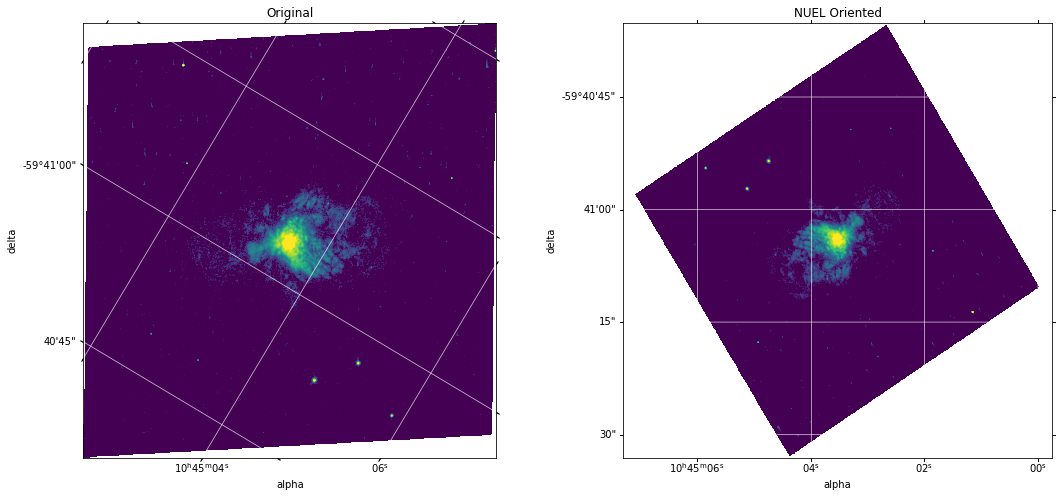

In [6]:
plt.figure(figsize=(18, 8))

vmin = 1
vmax = 100
cmap = 'viridis'
norm = colors.LogNorm(vmin, vmax, clip=True)

ax1 = plt.subplot(1, 2, 1, projection=wcs_in)
im1 = ax1.imshow(hdu['SCI'].data, origin='lower', cmap=cmap, norm=norm)
ax1.set_xlabel('alpha')
ax1.set_ylabel('delta')
ax1.set_title('Original')
ax1.grid(color='white', ls='-', alpha=0.7)

ax2 = plt.subplot(1, 2, 2, projection=wcs_out)
im2 = ax2.imshow(array, origin='lower', cmap=cmap, norm=norm)
ax2.set_xlabel('alpha')
ax2.set_ylabel('delta')
ax2.set_title('NUEL Oriented')
ax2.grid(color='white', ls='-', alpha=0.7)

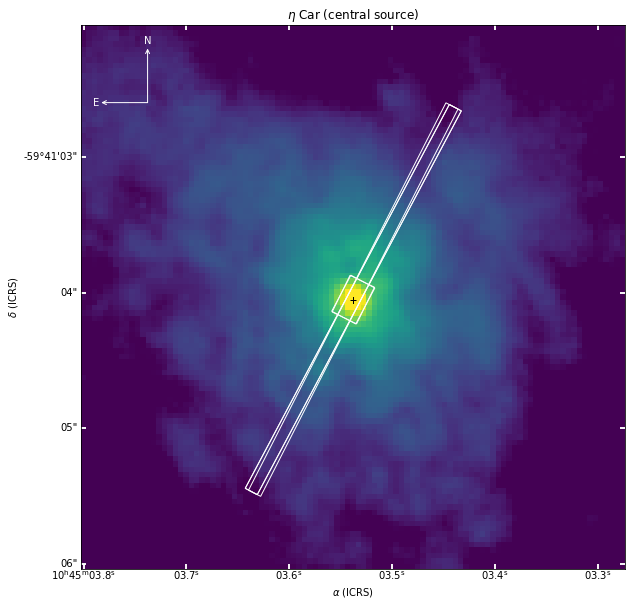

In [13]:
plt.figure(figsize=(10, 10))

# size of the cutout image (relative to the central source coordinates)
size = u.Quantity((4, 4), u.arcsec)
cutout = Cutout2D(array, etc_coords, size, wcs=wcs_out)
wcs_cutout = cutout.wcs

vmin = 10
vmax = 10000
cmap = 'viridis'
norm = colors.LogNorm(vmin, vmax)

ax = plt.subplot(projection=wcs_cutout)
# ax.set_aspect('equal')
ax.tick_params(axis='x', direction='in', color='white', width=1.5, length=5)
ax.tick_params(axis='y', direction='in', color='white', width=1.5, length=5)

ax.set_xlabel(r'$\alpha$ (ICRS)')
ax.set_ylabel(r'$\delta$ (ICRS)')
ax.set_title(r'$\eta$ Car (central source)')
# ax.grid(color='white', ls='-', alpha=0.25)

# mark central source coord
ax.plot_coord(etc_coords, '+', color='black')

# slit properties
slits = [
    {
        'date': '2000-03-20',
        'aperture': '3.2x0.1',
        'pa': '-28'
    },
    {
        'date': '2003-09-21',
        'aperture': '0.3x0.2',
        'pa': '154'
    },
    {
        'date': '2003-09-22',
        'aperture': '3.2x0.1',
        'pa': '153'
    },
    {
        'date': '2004-03-06',
        'aperture': '0.3x0.2',
        'pa': '-28'
    },
    {
        'date': '2018-04-21',
        'aperture': '3.2x0.1',
        'pa': '-28'
    },
]

# add slits
for slit in slits:
    slit_xc = etc_coords.ra + u.Quantity(0, 'arcsec')
    slit_yc = etc_coords.dec + u.Quantity(0, 'arcsec')
    slit_width = u.Quantity(slit.get('aperture').lower().split('x')[1], 'arcsec')
    slit_height = u.Quantity(slit.get('aperture').lower().split('x')[0], 'arcsec')
    slit_pa = u.Quantity(slit.get('pa'), 'deg')
    # create slit region in sky coords
    slit = RectangleSkyRegion(
        center=SkyCoord(slit_xc, slit_yc, frame='icrs'),
        width=slit_width,
        height=slit_height,
        angle=slit_pa,
        visual=RegionVisual({'edgecolor': 'white'}),
    )
    # SkyRegion objects do not have .as_artist method so we need to convert it to a PixelRegion object first
    ax.add_artist(slit.to_pixel(wcs_cutout).as_artist())

# add compass
size = [u.Quantity(0.75, 'arcsec').to('deg').to_value(), u.Quantity(0.45, 'arcsec').to('deg').to_value()]
xy = (etc_coords.ra + u.Quantity(3, 'arcsec')).to_value(), (etc_coords.dec + u.Quantity(1.45, 'arcsec')).to_value()
scale = ax.wcs.pixel_scale_matrix
scale /= np.sqrt(np.abs(np.linalg.det(scale)))
[ax.annotate(
        label,
        xy, xy + size * n * flip_factor,
        ax.get_transform('icrs'), ax.get_transform('icrs'),
        ha='center', va='center',
        arrowprops=dict(arrowstyle='<-', shrinkA=0.0, shrinkB=0.0, color='white'),
        clip_on=True,
        color='white'
    ) for n, s, label, flip_factor in zip(scale, size, 'EN', [-1, 1])]

im = ax.imshow(cutout.data, origin='lower', cmap=cmap, norm=norm)